# Прогнозирование количества заказов такси
Цель проекта - спроектировать систему прогнозирования количества заказов такси на основе исторических данных. Это необходимо для привлечения большего числа водителей в период пиковой нагрузки.      

Исследование основано на исторических данных о **количестве заказов такси** (целевой признак). Внешние признаки (например, район заказа, погодные условия и т.п.) отсутствуют.    

План работы:  
- Подготовка к исследованию, загрузка данных и библиотек
- Анализ временного ряда
- Декомпозиция и предобработка
- Разработка и сравнение нескольких моделей пронозирования
- Проверка модели с наилучшими показателями

## Оглавление<a id="0"></a>

- [Подготовка](#01)
- [Анализ](#1)
 - [Обзор данных](#11)
 - [Декомпозиция](#12)
 - [Статистические тесты](#13)
 - [Дифференцирование](#14)
- [Разработка модели](#2)
 - [SARIMA](#21)
 - [Линейная регрессия](#22)
 - [Бустинг](#23)
- [Выбор лучшей модели](#3)
- [Тестирование](#4)
- [Заключение](#5)
#### Подготовка<a id="01"></a>
Загрузка необходимых библиотек, установка настроек.

In [1]:
%%capture
import random

!pip install --upgrade pandas
!pip install --upgrade numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install --upgrade seaborn
import seaborn as sns
sns.set(font_scale = 1.0, style="darkgrid")

    
!pip install --upgrade statsmodels
import statsmodels.api as sm
from statsmodels.stats.stattools import medcouple
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.stats import shapiro, boxcox, boxcox_normmax
from scipy.special import inv_boxcox

!pip install --upgrade sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

try:
    import phik
except ModuleNotFoundError:
    !pip install phik
    import phik
    
try:
    import xgboost as xgb
except ModuleNotFoundError:
    !pip install xgboost
    import xgboost as xgb

try:
    import optuna
    from optuna.pruners import MedianPruner
    from optuna.visualization import plot_optimization_history
except ModuleNotFoundError:
    !pip install optuna
    import optuna
    from optuna.pruners import MedianPruner
    from optuna.visualization import plot_optimization_history
    
try: 
    from tqdm import tqdm
except ModuleNotFoundError:
    !pip install tqdm
    from tqdm import tqdm

%config Completer.use_jedi = False

#### Загрузка данных

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data = data.sort_values('datetime')

display(data.head())
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Ресемплируем данные по одному часу, как указано в ТЗ к проекту.

In [3]:
data = data.resample('1H').sum()

data['date'] = data.index.date
display(data.head())

,num_orders,date
datetime,,
2018-03-01 00:00:00,124,2018-03-01
2018-03-01 01:00:00,85,2018-03-01
2018-03-01 02:00:00,71,2018-03-01
2018-03-01 03:00:00,66,2018-03-01
2018-03-01 04:00:00,43,2018-03-01


   


- [В начало](#0)

## Анализ<a id="1"></a>
#### Обзор данных<a id="11"></a>

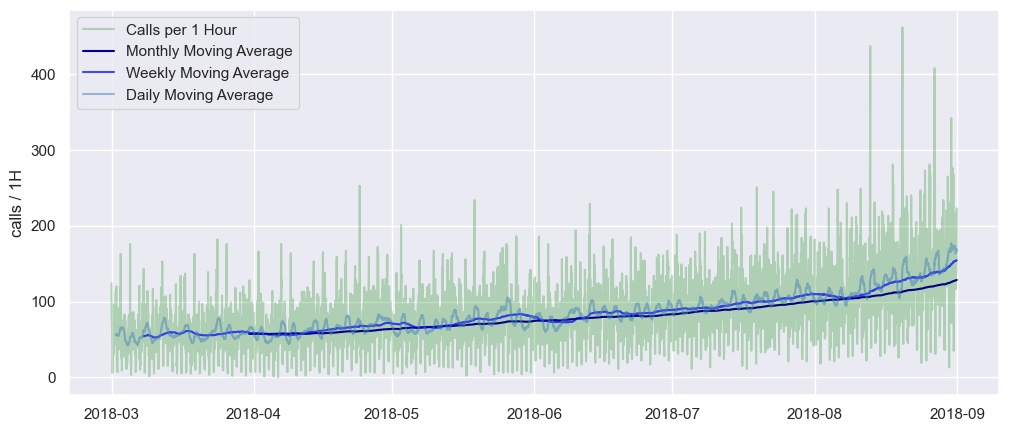

In [4]:
data['MA_24'] = data['num_orders'].shift(-1).rolling(24).mean()
data['MA_168'] = data['num_orders'].shift(-1).rolling(168).mean()
data['MA_720'] = data['num_orders'].shift(-1).rolling(720).mean()

fig, ax1 = plt.subplots(figsize=(12, 5))

sns.lineplot(x=data.index, y=data['num_orders'], alpha=.25, label='Calls per 1 Hour', color='green')
sns.lineplot(data=data, x='datetime', y='MA_720',
             label='Monthly Moving Average', color='navy')
sns.lineplot(data=data, x='datetime', y='MA_168',
             label='Weekly Moving Average', color='blue', alpha=.7)
sns.lineplot(data=data, x='datetime', y='MA_24',
             label='Daily Moving Average', color='steelblue', alpha=.5)

plt.ylabel('calls / 1H')
plt.xlabel('')
plt.show()
plt.close()

Количество заказов такси имеет равномерно восходящий тренд. Выделить сезонные зависимости на данном этапе невозможно, для этого нужна декомпозиция временного ряда.

#### Декомпозиция<a id="12"></a>
Для наглядного представления декомпозиции используем самописный класс. Он позволит как, непосредственно, декомпозировать ряд, так и отрисовывать следующие графики:
- временной ряд, тренд, сезонность, остатки, изменение коэффициента вариации (если меняется - это мультипликативная модель, если почти нет - аддитивная).
- тренд, сезонность, остатки для случайного периода заданной длинны (в днях, по умолчанию 7)
- распределение, квантильный график остатков

In [5]:
class MyDecomposer:
    def __init__(self,
                 data=data,
                 timeseries_data_column = 'num_orders',
                 extrapolate_trend='freq',
                 model='multiplicative',
                 period=24):
        self.data = data
        self.timeseries_data_column = timeseries_data_column
        self.model = model
        self.period = period
        self.extrapolate_trend = extrapolate_trend
        
        if model == 'multiplicative':
            data.loc[data[timeseries_data_column] < 1, timeseries_data_column] = 1
    
    # декомпозиция временного ряда, возвращает .trend, .seasonal и .resid
    def decompose(self):
        return seasonal_decompose(self.data[self.timeseries_data_column],
                                  model=self.model,
                                  period=self.period,
                                  extrapolate_trend=self.extrapolate_trend)
    
    # отрисовка декомпозированного ряда на графике
    def plot_decomposed(self):
        
        # рассчёт коэффициента вариации с разбивкой по неделям
        num_orders_weeks = np.array_split(self.data[self.timeseries_data_column], int((len(data) / 24) / 7))
        CVs = [np.std(segment) / abs(np.mean(segment)) for segment in num_orders_weeks]
        CVdates = [segment.index[0] for segment in num_orders_weeks]
        
        # декомпозиция
        decomposed = self.decompose()
        
        # график
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

        sns.lineplot(x=data.index, y=data[self.timeseries_data_column], ax=ax1, legend=False)
        sns.lineplot(x=data.index, y=decomposed.trend, ax=ax2, legend=False)
        sns.lineplot(x=data.index, y=decomposed.seasonal, ax=ax3, legend=False)
        sns.lineplot(x=data.index, y=decomposed.resid, ax=ax4, legend=False)

        for ax, label in zip([ax1, ax2, ax3, ax4],
                             ['Calls / 1H', 'Trend', 'Seasonal', 'Residuals']):
            plt.sca(ax)
            plt.ylabel(label)
        ax5 = ax1.twinx()
        ax5.step(x=CVdates, y=CVs, where='post', color='white', lw=3)
        ax5.step(x=CVdates, y=CVs, where='post', color='r', lw=1)
        plt.sca(ax5)
        plt.ylabel('Variance Coefficient\n(weekly)', color='r')
        ax5.grid(False)
        
        # ( plt.suptitle() в данном варианте работает некорректно )
        plt.text(x=.5, y=1.1, s=f'Decomposed Timeseries',
                 fontsize=18, ha='center', c='black', va='top',
                 rotation=0, transform=ax1.transAxes)
        
        plt.xlabel('')
        plt.subplots_adjust(hspace = 0.01)
        plt.show()
        plt.close()
    
    # отрисовка случайного периода заданной длинны
    def scope_decomposed(self, days_scoped=7):
        self.days_scoped = days_scoped
        start_time = 24 * random.randint(0, (len(data) / 24) - days_scoped)
        end_time = (start_time + 24 * days_scoped)
        
        decomposed = self.decompose()

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

        sns.lineplot(x=decomposed.trend[start_time:end_time].index,
                     y=decomposed.trend[start_time:end_time], ax=ax1, legend=False)
        sns.lineplot(x=decomposed.seasonal[start_time:end_time].index,
                     y=decomposed.seasonal[start_time:end_time], ax=ax2, legend=False)
        sns.scatterplot(x=decomposed.resid[start_time:end_time].index,
                     y=decomposed.resid[start_time:end_time], ax=ax3, legend=False)
        
        if self.model == 'multiplicative':
            base = 1
        else:
            base = 0
        plt.vlines(x=decomposed.resid[start_time:end_time].index, ymin=base,
                   ymax=decomposed.resid[start_time:end_time], linewidth=1)
        plt.axhline(base, c='black', ls='--', lw=0.5)
        
        plt.text(x=.5, y=1.15, s=f'Decomposed Timeseries (scoped random {days_scoped} days)',
                 fontsize=18, ha='center', c='black', va='top',
                 rotation=0, transform=ax1.transAxes)

        plt.xlabel('')
        plt.subplots_adjust(hspace = 0.01)
        plt.show()
        plt.close()
    
    # график распределения остстков
    def plot_resid_distributions(self):
        decomposed = self.decompose()

        fig = plt.figure(figsize=(10, 5))
        gr_shape = (1, 2)

        ax = [plt.subplot2grid(gr_shape, (0, 0)),
              plt.subplot2grid(gr_shape, (0, 1))]

        sns.histplot(decomposed.resid, ax=ax[0])
        sm.qqplot(decomposed.resid, line='q', ax=ax[1])
        
#         plt.text(x=.5, y=.98, s=f'medcouple = {medcouple(decomposed.resid).ravel()[0]:.3f}',
#                  fontsize=10, ha='center', c='black', va='top', transform=ax[0].transAxes)

        plt.suptitle('Residuals Distribution')
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # medcouple описывает скошенность распределения
        print(f'medcouple = {medcouple(decomposed.resid).ravel()[0]:.3f}')

# функция для отрисовки сразу всех графиков (дашборда)
def all_decomposed_plots(decomposer):
    decomposer.plot_decomposed()
    decomposer.scope_decomposed()
    decomposer.plot_resid_distributions()

Декомпозируем временной ряд со стандартными настройками (мультипликативный, период сезонности $24 H$)

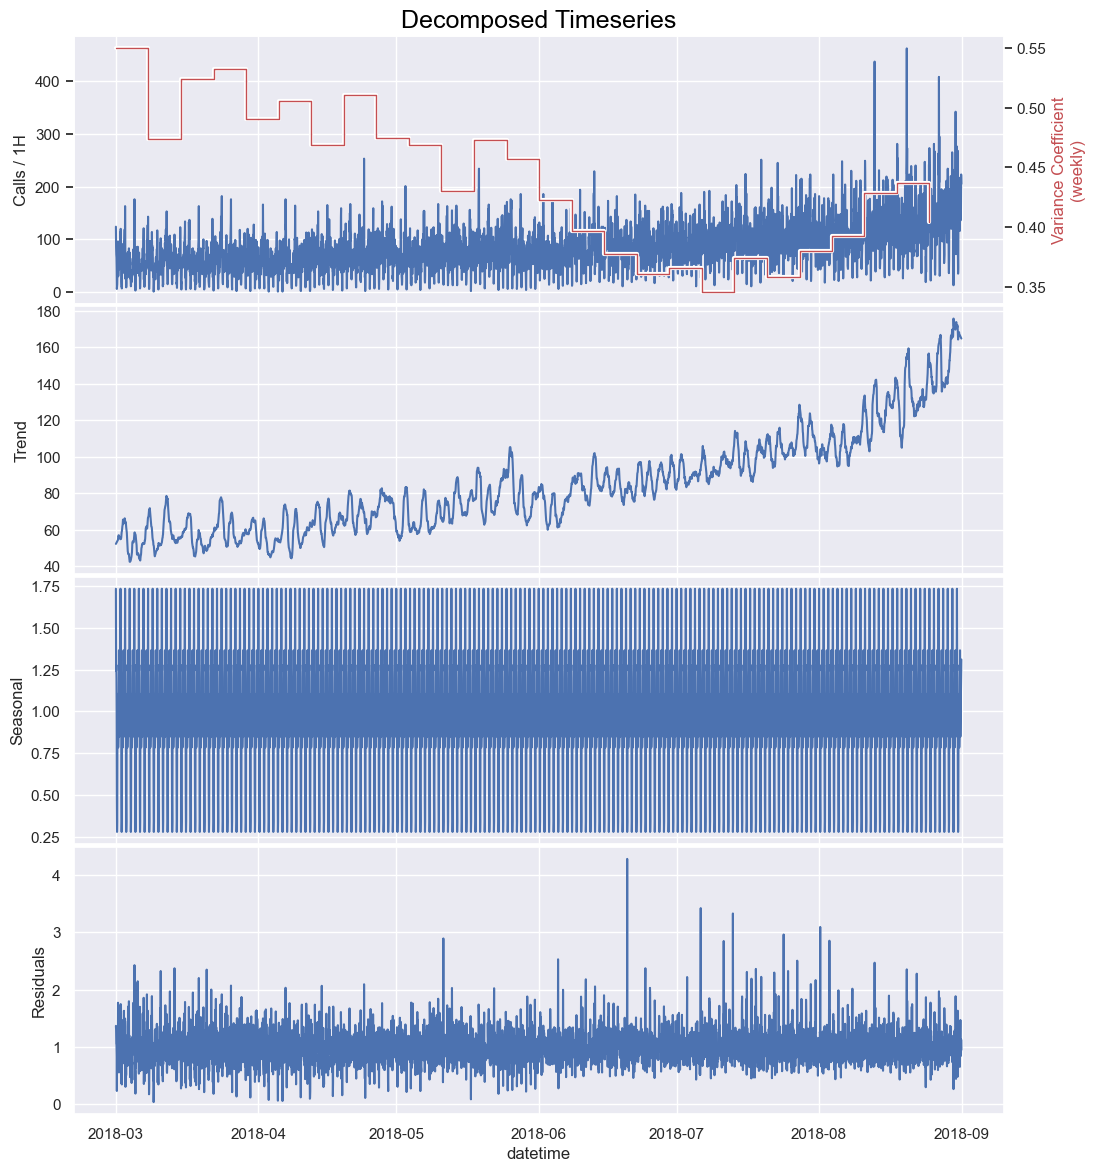

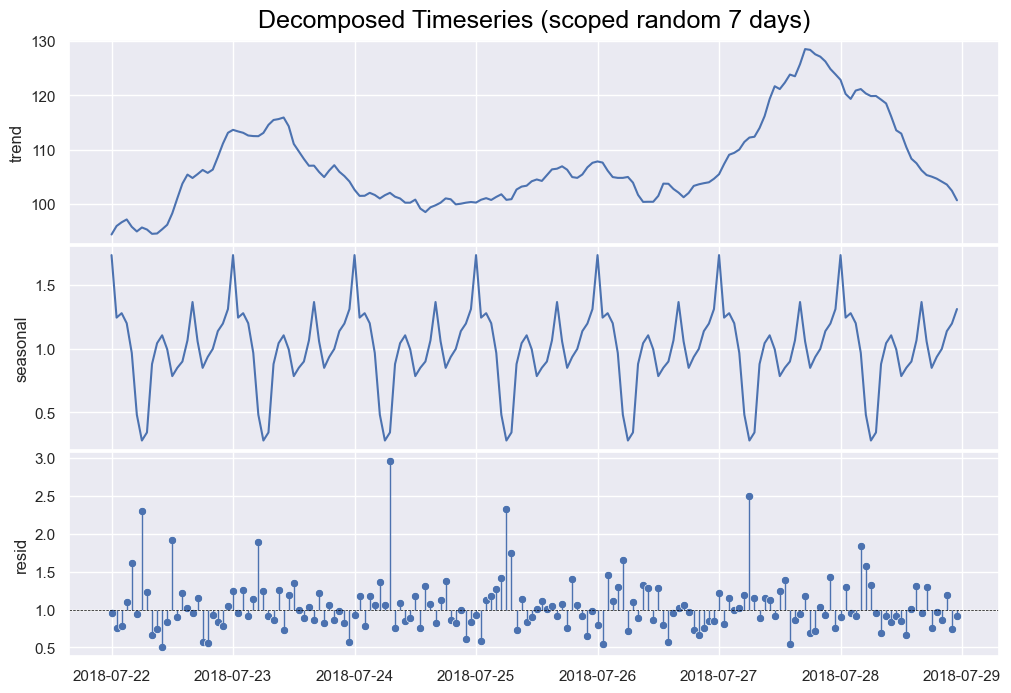

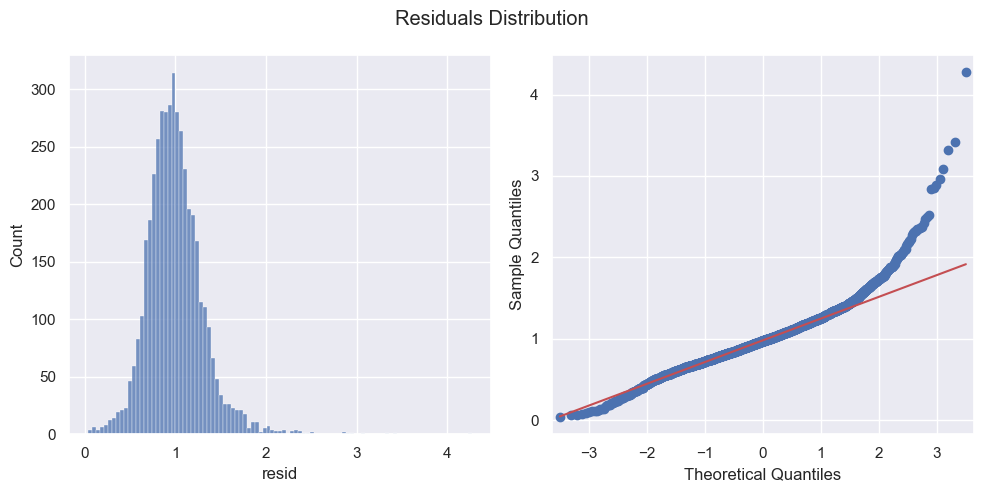

medcouple = 0.048


In [6]:
decompositor = MyDecomposer()
all_decomposed_plots(decompositor)

Ряд имеет мультипликативный характер, тренд восходящий, остатки распределены нормально, но есть выборсы.

#### Статтесты<a id="13"></a>
Проведем несколько тестов для определения статистических характеристик временного ряда.   

##### Стационарность временного ряда:   
Согласно [математическому определению теста Дики-Фуллера](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) нулевая гипотеза $H_0$ декларирует, что временной ряд имеет единиченый корень, то есть **нестационарен**.    
Напротив, альтернативная гипотеза $H_1$ подразумевает, что дисперсия ряда со временем не меняется, что указывает на **стационарность** ряда.

In [7]:
def stat_fuller(data, pval=.05):
    result = adfuller(data)

    print(f'p-value: {result[1]:.5f}')
    if result[1] > pval:
        print('Гипотеза о нестационарности ряда не отвергается. Временной ряд не стационарен.')
    else:
        print('Гипотеза о нестационарности ряда отвергается. Временной ряд стационарен.')
        
stat_fuller(data['num_orders'])

p-value: 0.02894
Гипотеза о нестационарности ряда отвергается. Временной ряд стационарен.


##### Нормальность распределения остатков:
Для проверки нормальности распределения остатков используем тест **Шапиро-Уилка**. Согласно $H_0$, остатки декомпозиции временного ряда распределены нормально. Согласно $H_1$ - гипотеха о нормальности отвергается, ряд не стационарен.

In [8]:
decomposed_not_stationary_ts = decompositor.decompose()

def stat_shapiro(decomposed_data, pval=.05):
    result = shapiro(decomposed_not_stationary_ts.resid.dropna().ravel())

    print(f'p-value: {result[1]}')
    if result[1] > pval:
        print('Гипотеза о нормальности распределения ряда не отвергается.')
    else:
        print('Гипотеза о нормальности распределения ряда отвергается.')
        
stat_shapiro(decomposed_not_stationary_ts)

p-value: 6.07824419288604e-40
Гипотеза о нормальности распределения ряда отвергается.


Вероятно, нормальность ряда не подтверждена из-за выбросов.

##### Автокорреляция:  
[Q-тест Льюнга-Бокса](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) позволяет проверить автокорреляцию сразу для нескольких порядков (то есть как автокорреляцию с предыдущим значением, так и с более отдалённым на временной шкале). Для каждого порядка $H_0$ дикларирует, что автокорреляция отсутствует. Согласно $H_1$ автокорреляция есть.

In [9]:
def stat_lungbox(decomposed_data, pval=.05):
    ljungbox_q = sm.stats.acorr_ljungbox(decomposed_data.resid.dropna().ravel())

    for i, j in zip(ljungbox_q['lb_pvalue'], range(len(ljungbox_q))):
        if i > pval:
            add = ',   автокорреляции нет.'
        else:
            add = ',   автокорреляция есть.'
        print(f"Порядок автокорреляции: {j+1},     p value: {i}" + add)

stat_lungbox(decomposed_not_stationary_ts)

Порядок автокорреляции: 1,     p value: 7.213088044004985e-11,   автокорреляция есть.
Порядок автокорреляции: 2,     p value: 4.588975052500485e-11,   автокорреляция есть.
Порядок автокорреляции: 3,     p value: 9.625582746420964e-11,   автокорреляция есть.
Порядок автокорреляции: 4,     p value: 1.3317202419207454e-10,   автокорреляция есть.
Порядок автокорреляции: 5,     p value: 1.6814737059203195e-12,   автокорреляция есть.
Порядок автокорреляции: 6,     p value: 2.3249704282876216e-23,   автокорреляция есть.
Порядок автокорреляции: 7,     p value: 8.809121081862744e-24,   автокорреляция есть.
Порядок автокорреляции: 8,     p value: 4.770677087581138e-28,   автокорреляция есть.
Порядок автокорреляции: 9,     p value: 1.8117564127547038e-38,   автокорреляция есть.
Порядок автокорреляции: 10,     p value: 2.5353476330853792e-46,   автокорреляция есть.


#### Дифференцирование временного ряда<a id="14"></a>

In [10]:
# дифференцирование
data['num_orders_diff'] = data['num_orders'].diff()
data['num_orders_diff'] = data['num_orders_diff'].mask(data['num_orders_diff'].isna(), 0)

# смещение для преобразования бокса-кокса, так как оно не может работать с отрицательными величинами
boxcox_byes = abs(data['num_orders_diff'].min() - 5)
# преобразование бокса-кокса
ts_boxcox, optimal_lambda = boxcox(data['num_orders_diff'] + boxcox_byes)
data['num_orders_diff_normalized'] = ts_boxcox

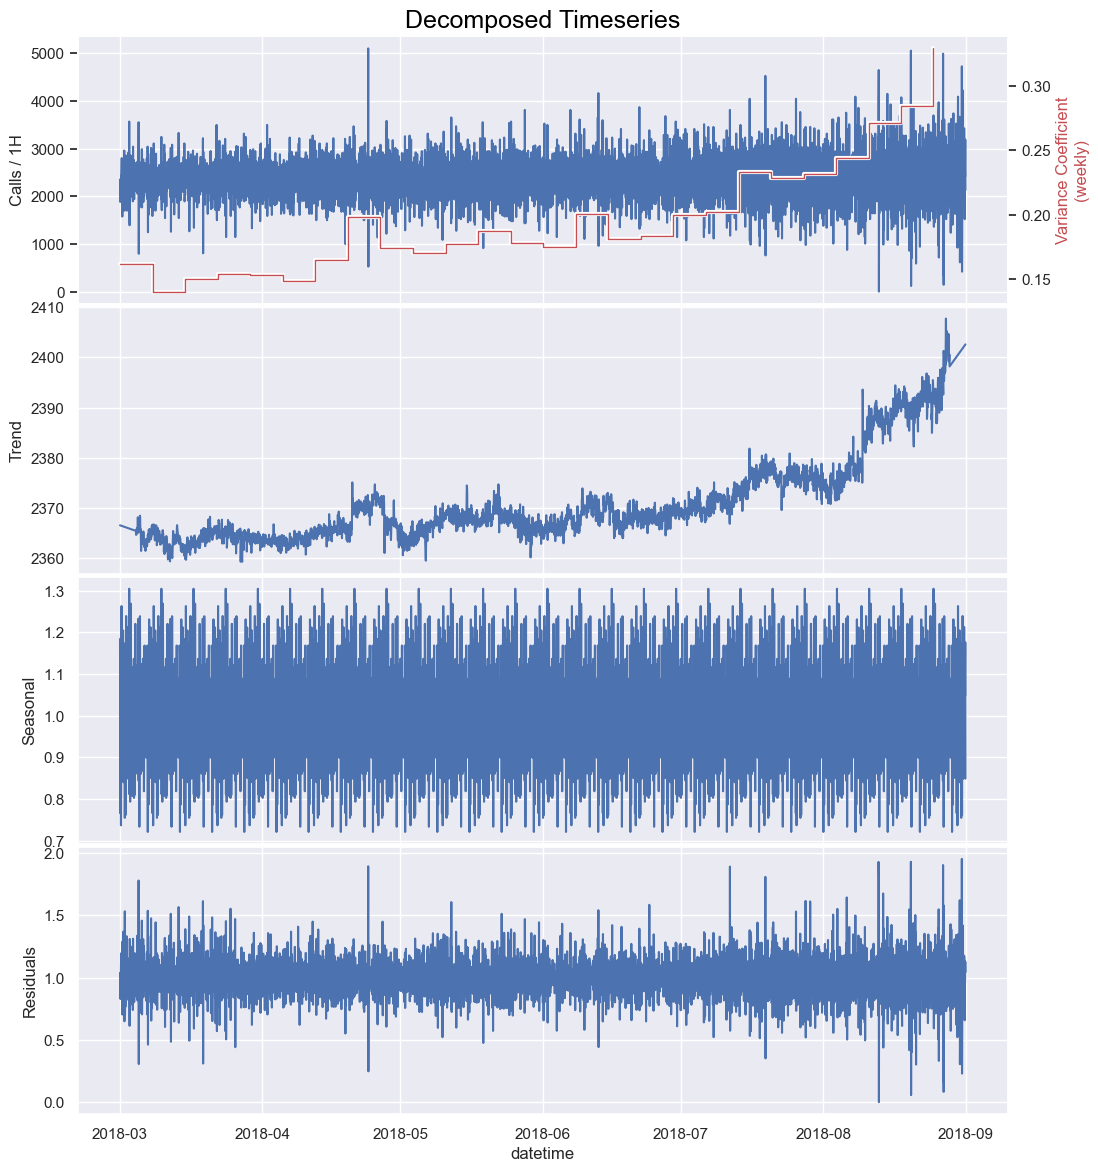

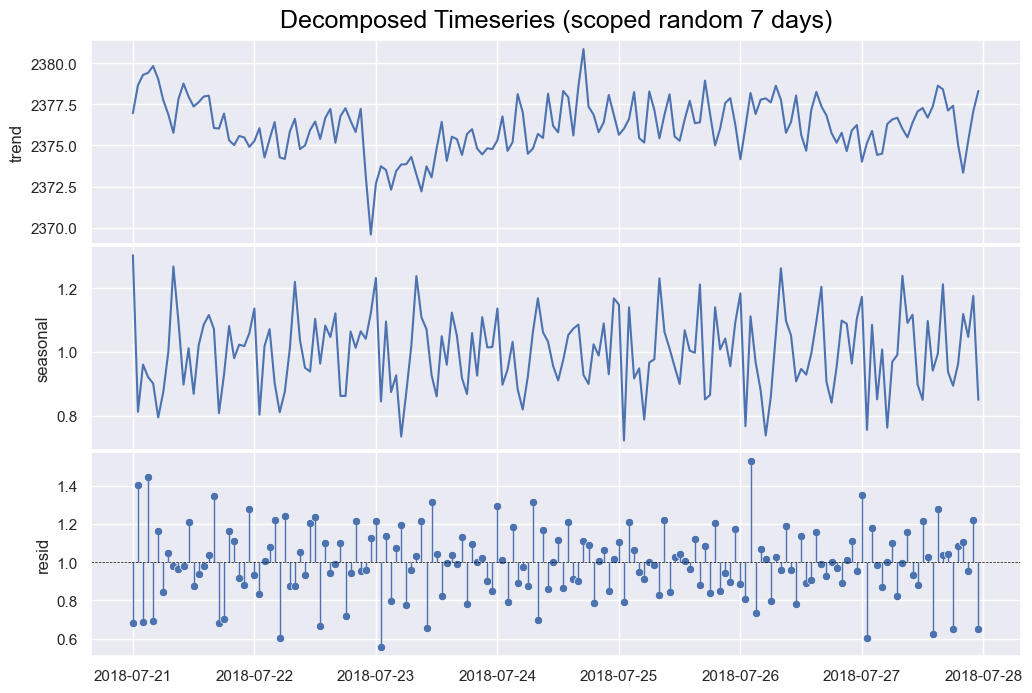

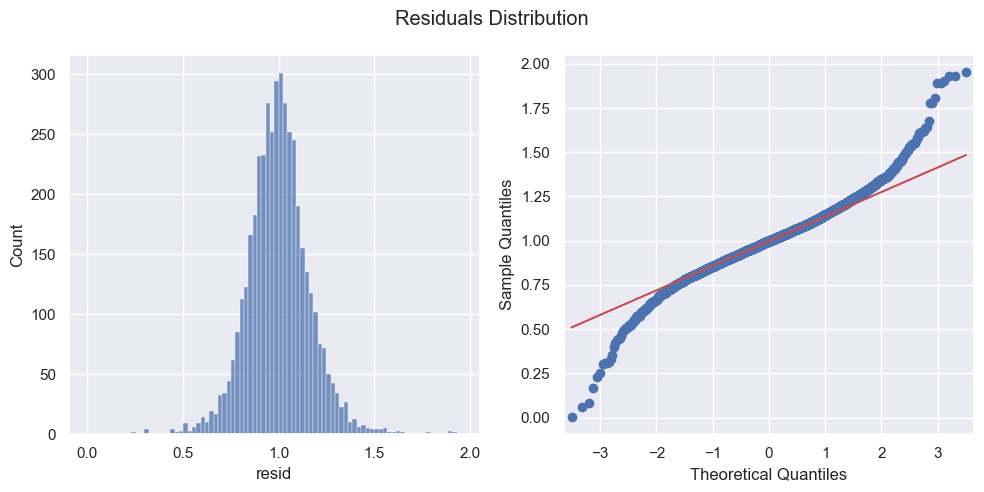

medcouple = 0.002


In [11]:
# обзор дифференцированного и центрированного временного ряда
decompositor_normalized = MyDecomposer(data=data,
                                       timeseries_data_column='num_orders_diff_normalized',
                                       model='multiplicative',
                                       period=24*7)

all_decomposed_plots(decompositor_normalized)

В данном случае применен недельный сезонный коэффициент. В дальнейшем при выборе модели будут подобраны разные сезонные коэффициенты, и выявлен оптимальный.   


- [В начало](#0)

## Разработка модели<a id="2"></a>

In [12]:
# разделение выборки на тренировочную, валидационную и тестовую в пропорциях 8/1/1
# (на тестовую и валидационную приходится по 10%)
len_data = len(data)
len_10_percent_data = int(len_data / 10)

data_test = data.iloc[len_data - len_10_percent_data :]
data_val = data.iloc[len_data - len_10_percent_data *2 : len_data - len_10_percent_data]
data_train = data.iloc[: len_data - len_10_percent_data * 2]

print(data_train.shape, data_test.shape, data_val.shape)

(3534, 7) (441, 7) (441, 7)


#### SARIMA<a id="21"></a>
##### (Seasonal Autoregressive Integrated Moving Average)
Это статистическая модель для прогнозирования рядов с учётом сезонности. Оптимальные параметры `order` и `seasonal_order` подобраны вручную, так как автоматический подбор мог бы занять неоправданно много времени.

In [13]:
%%time
model = SARIMAX(data_train['num_orders'], order=(3, 1, 1), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit(disp=1)

CPU times: total: 3min 12s
Wall time: 3min 49s


In [14]:
# функция для отрисовки результатов прогноза
def plot_predictions(true, pred):
    result_SARIMA = pd.DataFrame({'true': true, 'pred': pred})
    result_SARIMA['pred'] = result_SARIMA['pred'].astype('int')
    result_SARIMA['error'] = result_SARIMA['pred'] - result_SARIMA['true']

    result_SARIMA_0 = result_SARIMA[result_SARIMA['error'].isin(range(-50, 50))]
    result_SARIMA_1 = result_SARIMA[(result_SARIMA['error'].isin(range(-75, -51))) | (result_SARIMA['error'].isin(range(51, 75)))]
    result_SARIMA_2 = result_SARIMA[(result_SARIMA['error'] < -75) | (result_SARIMA['error'] > 75)]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    sns.lineplot(x=true.index, y=true, ax=ax1, label='true values')
    sns.lineplot(x=pred.index, y=pred, ax=ax1, label='predicted values')

    ax1.text(x=.02, y=.85, s=f"RMSE:   {np.sqrt(mean_squared_error(true, pred)):.1f}",
                     fontsize=12, ha='left', c='black', va='top',
                     rotation=0, transform=ax1.transAxes)
    plt.sca(ax1)
    plt.ylabel('calls / 1H')
    plt.legend(loc="upper left")


    ax2.axhline(0, c='black', ls='--', lw=0.7)

    sns.scatterplot(x=result_SARIMA_0.index, y=result_SARIMA_0['error'], color='steelblue', s=50, ax=ax2)
    ax2.vlines(x=result_SARIMA_0.index, ymin=0, ymax=result_SARIMA_0['error'], color='steelblue', linewidth=1)
    sns.scatterplot(x=result_SARIMA_1.index, y=result_SARIMA_1['error'], color='darkorange', s=50, ax=ax2)
    ax2.vlines(x=result_SARIMA_1.index, ymin=0, ymax=result_SARIMA_1['error'], color='darkorange', linewidth=1)
    sns.scatterplot(x=result_SARIMA_2.index, y=result_SARIMA_2['error'], color='red', s=50, ax=ax2)
    sns.scatterplot(x=result_SARIMA_2.index, y=result_SARIMA_2['error'], color='black', s=20, ax=ax2)
    ax2.vlines(x=result_SARIMA_2.index, ymin=0, ymax=result_SARIMA_2['error'], color='black', linewidth=1)
    
    ax2.text(x=.02, y=.05,
             s=f"ERROR STATISTICS\nmedian: {np.median(result_SARIMA['error']):.1f}" +
             f"\nmean: {np.mean(result_SARIMA['error']):.1f}\nstd: {np.std(result_SARIMA['error']):.1f}",
                     fontsize=10, ha='left', c='black', va='bottom',
                     rotation=0, transform=ax2.transAxes)

    plt.sca(ax2)
    plt.xticks(rotation=90)
    plt.ylabel('error')
    plt.xlabel('')
    plt.subplots_adjust(hspace = 0.01)
    plt.show()
    plt.close()

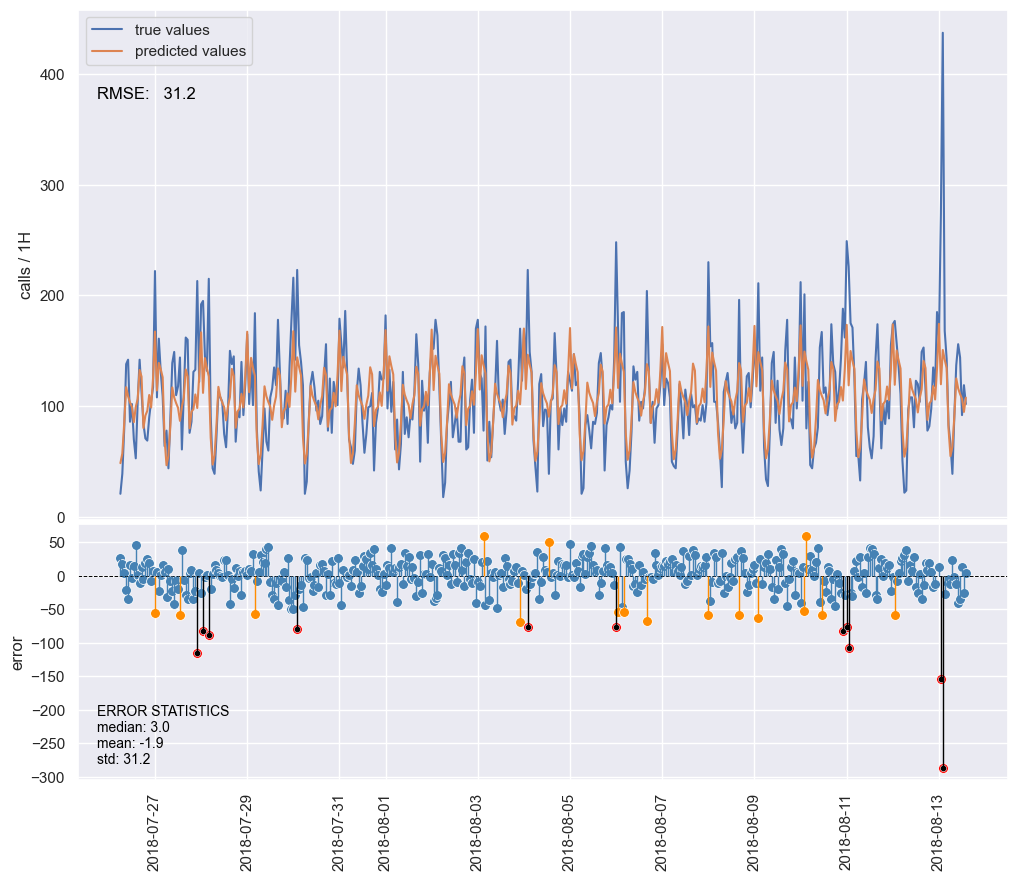

In [15]:
# предсказание для валидационной выборки
predictions = model_fit.predict(start=len(data_train), end=len(data_val) + len(data_train) - 1)
plot_predictions(data_val['num_orders'], predictions)

Модель хорошо усваивает сезонную составляющую, в среднем (по медиане) немного смещает предсказания в сторону повышения, однако есть отдельные ошибки недооценки целевого признака.

#### Linear Regression<a id="22"></a>
Циклические признаки закодированы синусом и косинусом, однако номер месяца в текущих условиях решено оставить незакодированным, так как с ростом числа месяца тренд стабильно повышается. При адаптировании модели к длительному использорванию и сохранении растущего тренда можно номер месяца в году заменить номером месяца с начала наблюдений.

In [16]:
# второй ряд декомпозиции сезонности (4-недельный)
decompositor_normalized_24_period = MyDecomposer(data=data,
                                       timeseries_data_column='num_orders_diff_normalized',
                                       model='multiplicative',
                                       period=24*7*4)


data['hour'] = data.index.hour
data['dayofweek'] = data.index.dayofweek
data['month'] = data.index.month
data['seasonal_1'] = decompositor_normalized.decompose().seasonal
data['seasonal_2'] = decompositor_normalized_24_period.decompose().seasonal

# кодирование циклич. признаков
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data.head(3)

,num_orders,date,MA_24,MA_168,MA_720,num_orders_diff,num_orders_diff_normalized,hour,dayofweek,month,seasonal_1,seasonal_2,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018-03-01,NaN,NaN,NaN,0.0,2355.034650,0,3,3,1.184373,1.083605,0.000000,1.000000,0.433884,-0.900969
2018-03-01 01:00:00,85,2018-03-01,NaN,NaN,NaN,-39.0,1885.013756,1,3,3,0.766537,0.802833,0.258819,0.965926,0.433884,-0.900969
2018-03-01 02:00:00,71,2018-03-01,NaN,NaN,NaN,-14.0,2182.597040,2,3,3,1.111868,1.044428,0.500000,0.866025,0.433884,-0.900969


Для обучения модели будет использован дифференцированный ряд.

In [17]:
model_cols = ['seasonal_1', 'seasonal_2',
                         'month',
#                          'month_sin', 'month_cos',
                         'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'num_orders_diff']

data_ml_target = data[model_cols[-1]]
data_ml_features = data[model_cols[:-1]]

X_train = data_ml_features.loc[data_train.index]
X_val = data_ml_features.loc[data_val.index]
X_test = data_ml_features.loc[data_test.index]
y_train = data_ml_target.loc[data_train.index]
y_val = data_ml_target.loc[data_val.index]
y_test = data_ml_target.loc[data_test.index]

display(X_train.head(3))
display(y_train.head(3))
print('')
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

,seasonal_1,seasonal_2,month,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
datetime,,,,,,,
2018-03-01 00:00:00,1.184373,1.083605,3,0.000000,1.000000,0.433884,-0.900969
2018-03-01 01:00:00,0.766537,0.802833,3,0.258819,0.965926,0.433884,-0.900969
2018-03-01 02:00:00,1.111868,1.044428,3,0.500000,0.866025,0.433884,-0.900969


datetime
2018-03-01 00:00:00     0.0
2018-03-01 01:00:00   -39.0
2018-03-01 02:00:00   -14.0
Freq: H, Name: num_orders_diff, dtype: float64


(3534, 7) (441, 7) (441, 7)
(3534,) (441,) (441,)


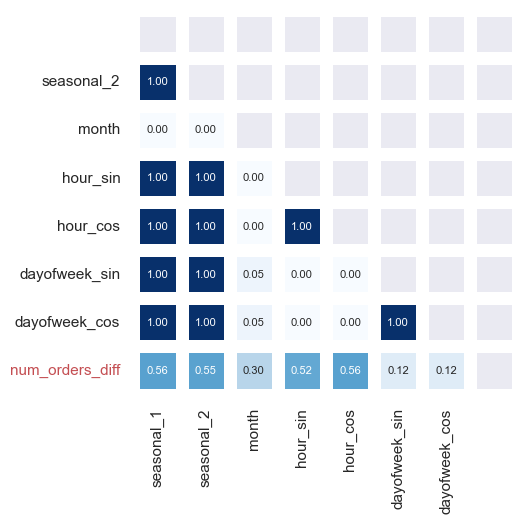

In [18]:
plt.figure(figsize=(5, 5))
corr = data[model_cols].phik_matrix(interval_cols=[], dropna=False)
mask = np.triu(np.ones_like(corr, dtype='bool'))

ax = sns.heatmap(corr, linewidths=8, annot=True, mask=mask,
                 annot_kws={'size': 8}, fmt='.2f', cbar=False, square = True,
                 cmap='Blues')

ax.yaxis.get_ticklabels()[-1].set_color('r')
ax.yaxis.get_ticklabels()[0].set_color('w')
ax.xaxis.get_ticklabels()[-1].set_color('w')

plt.xticks(rotation=90)
plt.show()
plt.close()

В наибольшей степени целевой признак коррелирует с сезонностью, а также со временем суток.  

При масштабировании признаков номер месяца масштабируется вместе с остальными признаками (не кодируется с помощью OHE), так как в данных условиях номер месяца линейно взаимосвязан с целевым признаком. 

In [19]:
MM_scaler = MinMaxScaler(feature_range=(-1, 1))
MM_scaler.fit(X_train)

X_train = MM_scaler.transform(X_train)
X_val = MM_scaler.transform(X_val)
X_test = MM_scaler.transform(X_test)

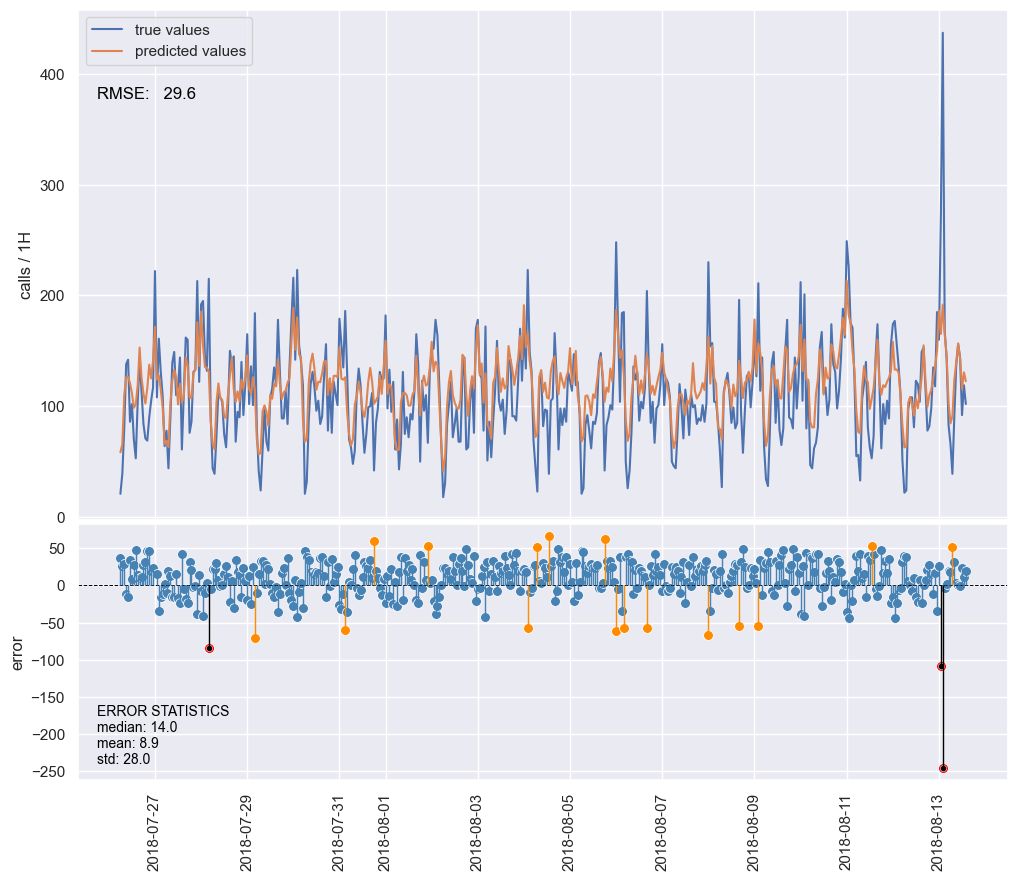

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

linear_reg_pred = pd.Series(model.predict(X_val).cumsum() + data_train.iloc[-1]['num_orders'],
                            index=data_val.index)

plot_predictions(data_val['num_orders'], linear_reg_pred)

Результат для линейной регрессии лучше, чем для SARIMA.


#### XGBoost<a id="23"></a>

Для подбора гиперпараметров регрессора XGBoost использована библиотека Optuna. Так как код поиска гиперпараметров отрабатывает долго, и на заключительной стадии, фактически, не нужен - он убран в `markdown`, но оставлен для наглядности.

```Python
def objective_XGB(trial):
    max_depth = trial.suggest_int('max_depth', low = 3, high = 20)   
    learning_rate = trial.suggest_float('learning_rate', low=0.001, high=1, log=True)
    n_estimators = trial.suggest_int('n_estimators', low = 100, high = 1000)
    subsample = trial.suggest_float('subsample', low=0.5, high=1, step=.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', low=0.7, high=1, step=.1)
    min_child_weight = trial.suggest_int('min_child_weight', low = 1, high = 5)
    reg_alpha = trial.suggest_float('reg_alpha', low=0.001, high=1, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', low=0.001, high=1, log=True)

    XGB_regressor = xgb.XGBRegressor(
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                subsample=subsample,
                                colsample_bytree=colsample_bytree,
                                min_child_weight=min_child_weight,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                verbosity = 0
                            )
    
    XGB_regressor.fit(X_train, data.loc[data_train.index, 'num_orders'])
    
    pred = pd.Series(XGB_regressor.predict(X_val), index=data_val.index)
    
    score = np.sqrt(mean_squared_error(data.loc[data_val.index, 'num_orders'], pred))    

    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', pruner=MedianPruner())

trials = 150
with tqdm(total=trials) as pbar:
    def callback(study, trial):
        pbar.update(1)
    study.optimize(objective_XGB,
                   n_trials=trials,
                   callbacks=[callback])

fig = plot_optimization_history(study)
fig.show()

print(f"best value (RMSE):   {study.best_value:.2f}")
print("best params:")
print(f"{study.best_params}")
```

In [21]:
# лучшие гиперпараметры XGBoost сохранены
XGB_best_params = {'max_depth': 4,
                   'learning_rate': 0.03,
                   'n_estimators': 511,
                   'subsample': 0.6,
                   'colsample_bytree': 1.0,
                   'min_child_weight': 3,
                   'reg_alpha': 0.00205,
                   'reg_lambda': 0.0658}

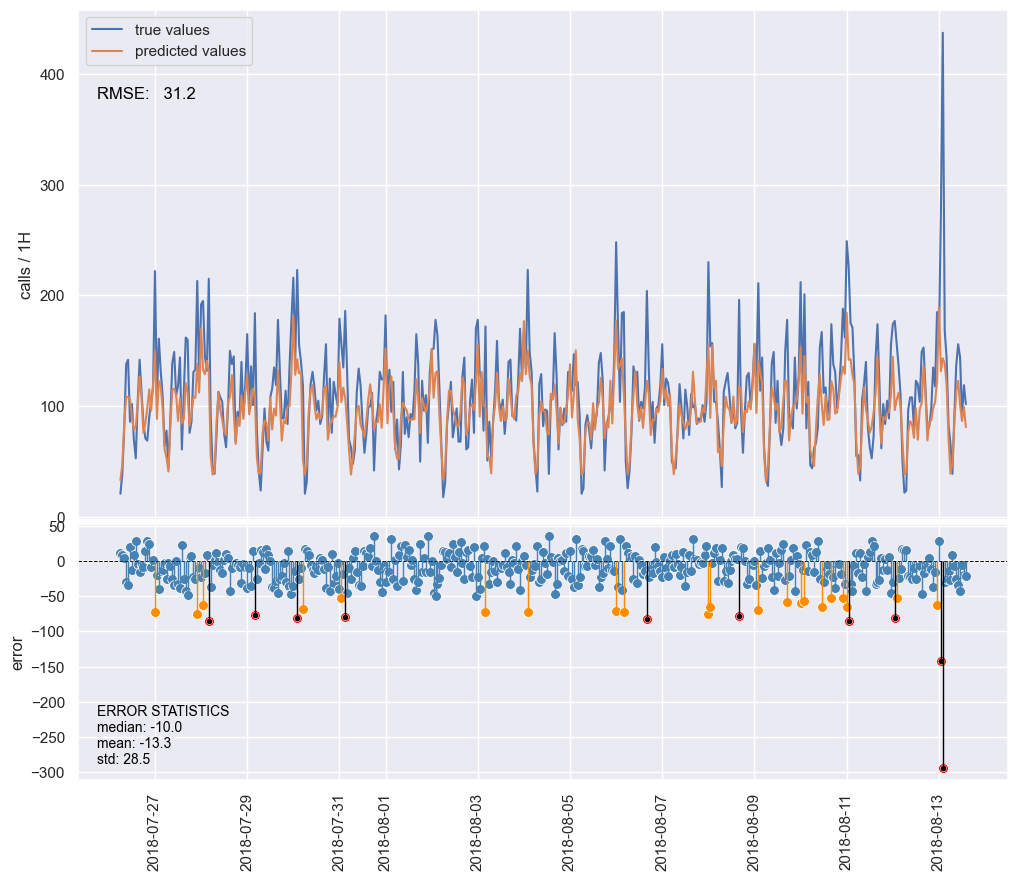

In [22]:
XGB = xgb.XGBRegressor(**XGB_best_params)
XGB.fit(X_train, data.loc[data_train.index, 'num_orders'])

xgb_reg_pred = pd.Series(XGB.predict(X_val),
                            index=data_val.index)

plot_predictions(data_val['num_orders'], xgb_reg_pred)

Даже после подбора гиперпараметров результативность регрессора XGBoost чуть ниже, чем у линейной регрессии.   


- [В начало](#0)

## Выбор модели<a id="3"></a>
Из протестированных моделей будет выбрана одна, с наиболее низким RMSE. Для визуальной простоты восприятия предсказаний от их значений произведены 12-часовые скользящие средние.

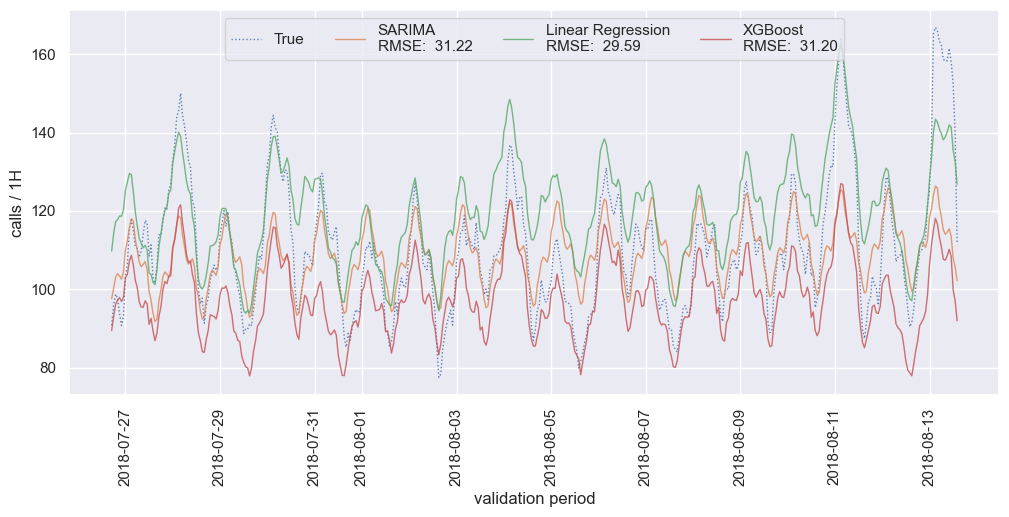

In [23]:
results_true = data_val['num_orders'].rolling(12).mean().dropna()
results_sarima = predictions.rolling(12).mean().dropna()
results_linear = linear_reg_pred.rolling(12).mean().dropna()
results_xgb = xgb_reg_pred.rolling(12).mean().dropna()

rmse_sarima = np.sqrt(mean_squared_error(data_val['num_orders'], predictions))
rmse_linear = np.sqrt(mean_squared_error(data_val['num_orders'], linear_reg_pred))
rmse_xgb = np.sqrt(mean_squared_error(data_val['num_orders'], xgb_reg_pred))

fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(x=results_true.index, y=results_true, alpha=.9, label='True', lw=1, ls=':')
sns.lineplot(x=results_sarima.index, y=results_sarima, alpha=.8, label=f'SARIMA\nRMSE:  {rmse_sarima:.2f}', lw=1)
sns.lineplot(x=results_linear.index, y=results_linear, alpha=.8, label=f'Linear Regression\nRMSE:  {rmse_linear:.2f}', lw=1)
sns.lineplot(x=results_xgb.index, y=results_xgb, alpha=.8, label=f'XGBoost\nRMSE:  {rmse_xgb:.2f}', lw=1)

plt.legend(ncol=4, loc="upper center")
plt.xticks(rotation=90)
plt.ylabel('calls / 1H')
plt.xlabel('validation period')
plt.show()
plt.close()

Не смотря на простоту исполнения, наиболее эффективной оказалась линейная регрессия. Она и будет использована для заключительного тестирования модели.   


- [В начало](#0)

## Тестирование   <a id="4"></a>

Проверим работу модели на отложенной выборке.

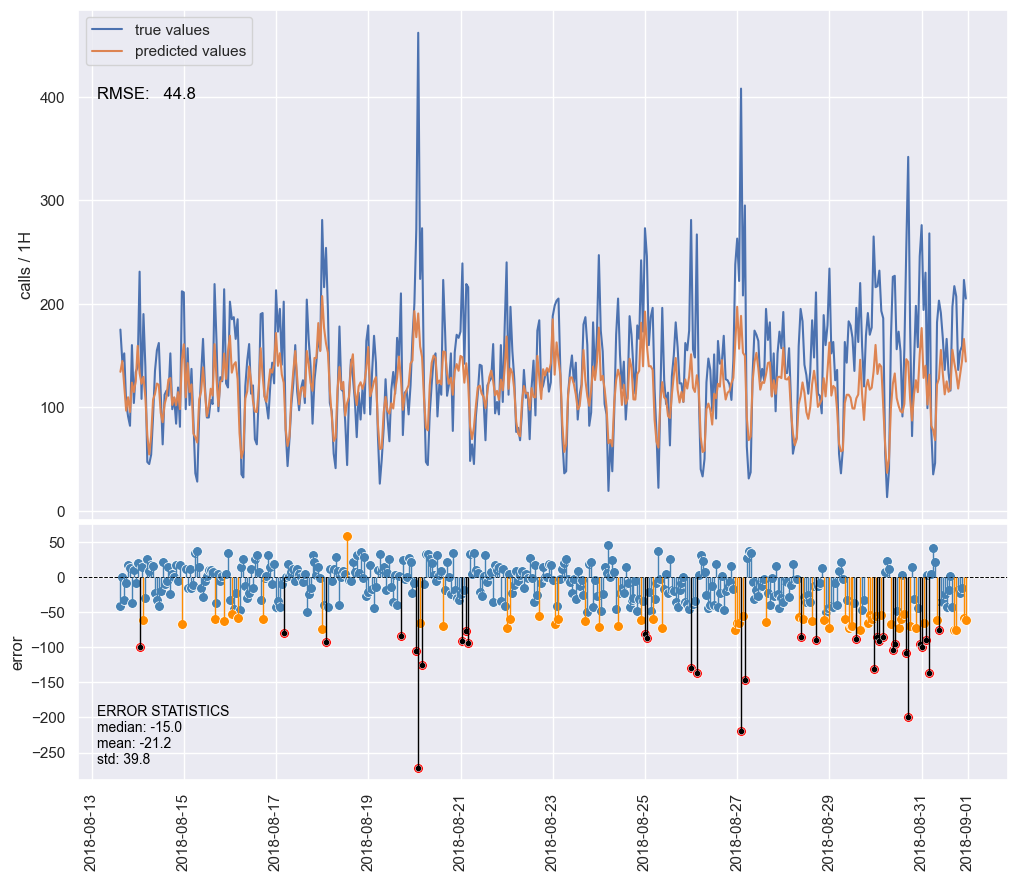

In [24]:
final_X_train = np.concatenate([X_train, X_val])
final_y_train = pd.concat([y_train, y_val])

model.fit(final_X_train, final_y_train)

linear_reg_pred_final = pd.Series(model.predict(X_test).cumsum() + data.loc[final_y_train.index[-1]]['num_orders'],
                            index=data_test.index)

plot_predictions(data_test['num_orders'], linear_reg_pred_final)

**RMSE** выше, чем на валидационной, но укладывается в рамки, установленные заданием. Высокая ошибка связана со значительными колебаниями количества вызовов такси в последний месяц наблюдаемого периода.

## Заключение<a id="5"></a>
В рамках проекта было протестировано три различные модели прогнозирования:
- SARIMA (статистическая модель)
- Linear Regression (регрессия)
- XGBoost (бустинг)

На валидационном этапе все три модели показали удовлетворительный результат. Наилучшая метрика (RMSE) на валидационном этапе наблюбдалась у **линейной регрессии**. На тестовом (заключительном) этапе линейная регрессия также показала удовлетворительную метрику (в рамках предъявленных требований). Рост ошибки был связан со значительными колебаниями целевой метрики на исходе наблюдаемого периода.    

##### Возможные улучшения
- дополнительная работа с признаками
- подбор оптимального паттерна декомпозиции временного ряда
- имплементация других моделей
- $*$ при наличии дополнительных признаков -например, условий погоды или географических признаков- также можно было бы улучшить качество предсказания.    


- [В начало](#0)